In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
from libs.models import dual_lstm
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(dual_lstm)

<module 'libs.models.dual_lstm' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py'>

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy  as np
import math
import matplotlib.pyplot as plt

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
# Build LSTM input tensors (disk-backed memmaps)
X, y_sig, y_ret, raw_close, end_times = models_core.build_tensors(
    df            = df_feat_sel,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape, "(samples,)")
print("  y_ret     =", y_ret.shape, "(samples,)")
print("  raw_close =", raw_close.shape)
print("  end_times =", end_times.shape)


Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2435400, 60, 17]) (samples, look_back, features)
  y_sig     = torch.Size([2435400]) (samples,)
  y_ret     = torch.Size([2435400]) (samples,)
  raw_close = torch.Size([2435400])
  end_times = (2435400,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models_core.chronological_split(
    X, y_sig, y_ret, raw_close,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1731840, 60, 17])
  y_sig_tr, y_ret_tr = torch.Size([1731840]) torch.Size([1731840])
  X_val = torch.Size([338701, 60, 17])
  y_sig_val, y_ret_val = torch.Size([338701]) torch.Size([338701])
  X_te  = torch.Size([364859, 60, 17])
  y_sig_te, y_ret_te = torch.Size([364859]) torch.Size([364859])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models_core.split_to_day_datasets(
    # train split:   
    X_tr,       y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,      y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,       y_sig_te,     y_ret_te,   end_times_te,     raw_close_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Days  → train=3840, val=751, test=809
Batches → train=60,   val=751,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = dual_lstm.DualMemoryLSTM(
    n_feats        = X.shape[-1],                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(params.device)  

model

DualMemoryLSTM(
  (conv): Conv1d(17, 17, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (short_lstm): LSTM(17, 32, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (ln_short): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (do_short): Dropout(p=0.25, inplace=False)
  (long_lstm): LSTM(64, 48, batch_first=True, bidirectional=True)
  (short2long): Linear(in_features=64, out_features=96, bias=True)
  (ln_long): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (do_long): Dropout(p=0.3, inplace=False)
  (pred): Linear(in_features=96, out_features=1, bias=True)
  (cls_head): Linear(in_features=96, out_features=1, bias=True)
  (cls_ter): Linear(in_features=96, out_features=3, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models_core.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0001
    lr: 0.0001
    maximize: False
    weight_decay: 0.001
)

In [9]:
# -----------------------------------------------------------------------------
# Helper: extract the true “signal” values from any loader into a flat array
# -----------------------------------------------------------------------------
def extract_y(loader):
    return np.concatenate([batch[1].cpu().numpy().ravel() for batch in loader])

# Pull out train & validation targets
y_train = extract_y(train_loader)
y_val   = extract_y(val_loader)

# -----------------------------------------------------------------------------
# 1) Zero‐forecast baseline RMSE (predict 0 always)
#    RMSE_zero = √(mean(y²))
# -----------------------------------------------------------------------------
rmse_zero_train = np.sqrt(np.mean(y_train**2))
rmse_zero_val   = np.sqrt(np.mean(y_val**2))
print(f"Zero‐forecast RMSE (predict 0): train = {rmse_zero_train:.6f},  val = {rmse_zero_val:.6f}\n")

# -----------------------------------------------------------------------------
# 2) Compute mean, variance & std for train/validation targets
#    and derive the mean‐predictor baseline (R² = 0)
# -----------------------------------------------------------------------------
for split, y in [("Train", y_train), ("Validation", y_val)]:
    mean_y    = y.mean()
    std_y     = y.std(ddof=0)     # population std = √variance
    var_y     = std_y**2
    rmse_mean = std_y            # RMSE_baseline = std(target)

    print(f"{split} target stats:")
    print(f"  mean = {mean_y:.4f},  var = {var_y:.4f},  std = {std_y:.4f}")
    print(f"{split} mean‐predictor baseline:")
    print(f"  RMSE_baseline = {rmse_mean:.6f}")
    print("  R²_baseline   = 0.00\n")

    if split == "Validation":
        rmse_mean_val = rmse_mean # used afterwards for the final reporting
        


Zero‐forecast RMSE (predict 0): train = 0.405952,  val = 0.409382

Train target stats:
  mean = 0.2836,  var = 0.0844,  std = 0.2905
Train mean‐predictor baseline:
  RMSE_baseline = 0.290471
  R²_baseline   = 0.00

Validation target stats:
  mean = 0.2919,  var = 0.0824,  std = 0.2870
Validation mean‐predictor baseline:
  RMSE_baseline = 0.287012
  R²_baseline   = 0.00



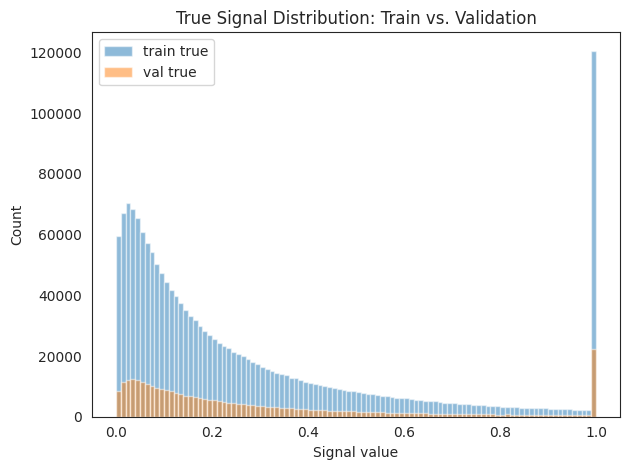

In [10]:
# Visualize the true‐signal distributions on train vs. validation
plt.hist(y_train, bins=100, alpha=0.5, label="train true")
plt.hist(y_val,   bins=100, alpha=0.5, label="val true")
plt.xlabel("Signal value")
plt.ylabel("Count")
plt.title("True Signal Distribution: Train vs. Validation")
plt.legend()
plt.tight_layout()
plt.show()


Training sees 3840 unique trading days per epoch.

Using HyperParameters:
 "look_back": 60 {'SHORT_UNITS': 64, 'LONG_UNITS': 96, 'DROPOUT_SHORT': 0.25, 'DROPOUT_LONG': 0.3, 'ATT_HEADS': 4, 'ATT_DROPOUT': 0.2, 'WEIGHT_DECAY': 0.001, 'TRAIN_BATCH': 64, 'VAL_BATCH': 1, 'NUM_WORKERS': 4, 'TRAIN_PREFETCH_FACTOR': 2, 'MAX_EPOCHS': 100, 'EARLY_STOP_PATIENCE': 7, 'LR_EPOCHS_WARMUP': 3, 'INITIAL_LR': 0.0001, 'CLIPNORM': 0.5, 'ETA_MIN': 1e-06, 'T_0': 100, 'T_MULT': 1, 'HUBER_BETA': 0.1, 'CLS_LOSS_WEIGHT': 0.05, 'PLATEAU_FACTOR': 0.9, 'PLATEAU_PATIENCE': 0, 'MIN_LR': 1e-06, 'PLAT_EPOCHS_WARMUP': 999}


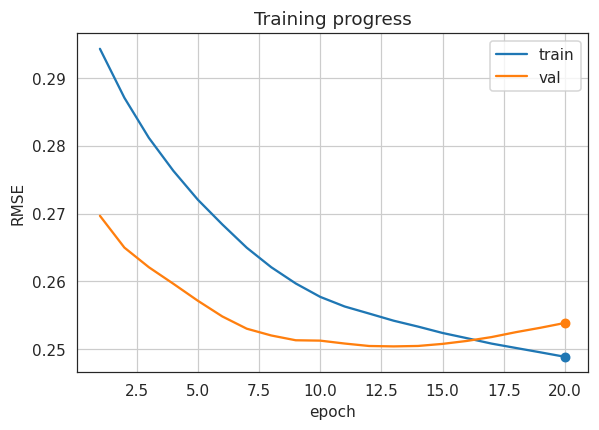

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2943 MAE=0.2256 R2=-0.0264 | Acc=0.6736 Prec=0.3393 Rec=0.1898 F1=0.2434 AUROC=0.5743
VALID→ RMSE=0.2697 MAE=0.1862 R2=0.1172 | Acc=0.7134 Prec=0.7430 Rec=0.0035 F1=0.0070 AUROC=0.7110
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26966_chp.pth


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2871 MAE=0.2194 R2=0.0234 | Acc=0.7197 Prec=0.4419 Rec=0.0505 F1=0.0907 AUROC=0.5570
VALID→ RMSE=0.2650 MAE=0.1849 R2=0.1477 | Acc=0.7314 Prec=0.7442 Rec=0.0990 F1=0.1747 AUROC=0.7275
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26497_chp.pth


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2811 MAE=0.2161 R2=0.0632 | Acc=0.7246 Prec=0.5130 Rec=0.0860 F1=0.1473 AUROC=0.5992
VALID→ RMSE=0.2621 MAE=0.1845 R2=0.1662 | Acc=0.7426 Prec=0.7082 Rec=0.1769 F1=0.2831 AUROC=0.7359
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.26208_chp.pth


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2763 MAE=0.2127 R2=0.0953 | Acc=0.7297 Prec=0.5474 Rec=0.1325 F1=0.2134 AUROC=0.6307
VALID→ RMSE=0.2596 MAE=0.1843 R2=0.1816 | Acc=0.7466 Prec=0.6942 Rec=0.2107 F1=0.3233 AUROC=0.7406
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25964_chp.pth


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2720 MAE=0.2095 R2=0.1229 | Acc=0.7359 Prec=0.5736 Rec=0.1762 F1=0.2696 AUROC=0.6549
VALID→ RMSE=0.2571 MAE=0.1843 R2=0.1973 | Acc=0.7488 Prec=0.6907 Rec=0.2275 F1=0.3423 AUROC=0.7437
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25714_chp.pth


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2684 MAE=0.2068 R2=0.1462 | Acc=0.7406 Prec=0.5837 Rec=0.2170 F1=0.3163 AUROC=0.6743
VALID→ RMSE=0.2548 MAE=0.1848 R2=0.2117 | Acc=0.7502 Prec=0.6879 Rec=0.2388 F1=0.3545 AUROC=0.7456
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25483_chp.pth


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2650 MAE=0.2038 R2=0.1680 | Acc=0.7451 Prec=0.5931 Rec=0.2507 F1=0.3524 AUROC=0.6932
VALID→ RMSE=0.2530 MAE=0.1855 R2=0.2228 | Acc=0.7516 Prec=0.6863 Rec=0.2495 F1=0.3659 AUROC=0.7468
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25302_chp.pth


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2621 MAE=0.2011 R2=0.1859 | Acc=0.7493 Prec=0.6040 Rec=0.2722 F1=0.3753 AUROC=0.7082
VALID→ RMSE=0.2520 MAE=0.1863 R2=0.2290 | Acc=0.7525 Prec=0.6850 Rec=0.2566 F1=0.3733 AUROC=0.7472
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25202_chp.pth


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2597 MAE=0.1991 R2=0.2007 | Acc=0.7519 Prec=0.6096 Rec=0.2866 F1=0.3899 AUROC=0.7187
VALID→ RMSE=0.2513 MAE=0.1869 R2=0.2333 | Acc=0.7532 Prec=0.6860 Rec=0.2601 F1=0.3772 AUROC=0.7479
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25132_chp.pth


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2577 MAE=0.1970 R2=0.2128 | Acc=0.7539 Prec=0.6161 Rec=0.2926 F1=0.3968 AUROC=0.7267
VALID→ RMSE=0.2513 MAE=0.1860 R2=0.2336 | Acc=0.7539 Prec=0.6898 Rec=0.2606 F1=0.3783 AUROC=0.7491
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25126_chp.pth


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2563 MAE=0.1959 R2=0.2215 | Acc=0.7549 Prec=0.6162 Rec=0.3025 F1=0.4058 AUROC=0.7321
VALID→ RMSE=0.2508 MAE=0.1863 R2=0.2362 | Acc=0.7542 Prec=0.6874 Rec=0.2647 F1=0.3823 AUROC=0.7496
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25084_chp.pth


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2553 MAE=0.1947 R2=0.2278 | Acc=0.7562 Prec=0.6204 Rec=0.3060 F1=0.4098 AUROC=0.7368
VALID→ RMSE=0.2505 MAE=0.1869 R2=0.2384 | Acc=0.7548 Prec=0.6836 Rec=0.2726 F1=0.3898 AUROC=0.7499
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25047_chp.pth


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2542 MAE=0.1937 R2=0.2341 | Acc=0.7572 Prec=0.6218 Rec=0.3124 F1=0.4158 AUROC=0.7413
VALID→ RMSE=0.2504 MAE=0.1872 R2=0.2388 | Acc=0.7551 Prec=0.6778 Rec=0.2810 F1=0.3973 AUROC=0.7502
🔖 Saved folder‐best checkpoint (_chp): AAPL_0.25041_chp.pth


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2533 MAE=0.1930 R2=0.2394 | Acc=0.7579 Prec=0.6217 Rec=0.3190 F1=0.4216 AUROC=0.7446
VALID→ RMSE=0.2505 MAE=0.1879 R2=0.2384 | Acc=0.7547 Prec=0.6704 Rec=0.2876 F1=0.4025 AUROC=0.7500


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2524 MAE=0.1921 R2=0.2450 | Acc=0.7587 Prec=0.6228 Rec=0.3241 F1=0.4263 AUROC=0.7477
VALID→ RMSE=0.2508 MAE=0.1881 R2=0.2365 | Acc=0.7540 Prec=0.6675 Rec=0.2862 F1=0.4006 AUROC=0.7497


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2516 MAE=0.1915 R2=0.2496 | Acc=0.7594 Prec=0.6240 Rec=0.3277 F1=0.4297 AUROC=0.7507
VALID→ RMSE=0.2512 MAE=0.1887 R2=0.2338 | Acc=0.7528 Prec=0.6614 Rec=0.2857 F1=0.3990 AUROC=0.7486


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2508 MAE=0.1908 R2=0.2543 | Acc=0.7604 Prec=0.6264 Rec=0.3320 F1=0.4339 AUROC=0.7535
VALID→ RMSE=0.2518 MAE=0.1900 R2=0.2304 | Acc=0.7515 Prec=0.6499 Rec=0.2924 F1=0.4034 AUROC=0.7468


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2502 MAE=0.1904 R2=0.2582 | Acc=0.7613 Prec=0.6274 Rec=0.3380 F1=0.4393 AUROC=0.7556
VALID→ RMSE=0.2525 MAE=0.1907 R2=0.2260 | Acc=0.7496 Prec=0.6398 Rec=0.2940 F1=0.4028 AUROC=0.7451


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2495 MAE=0.1899 R2=0.2620 | Acc=0.7620 Prec=0.6280 Rec=0.3426 F1=0.4433 AUROC=0.7580
VALID→ RMSE=0.2532 MAE=0.1909 R2=0.2220 | Acc=0.7489 Prec=0.6393 Rec=0.2889 F1=0.3980 AUROC=0.7441


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.2489 MAE=0.1892 R2=0.2659 | Acc=0.7629 Prec=0.6300 Rec=0.3459 F1=0.4466 AUROC=0.7597
VALID→ RMSE=0.2539 MAE=0.1915 R2=0.2176 | Acc=0.7474 Prec=0.6303 Rec=0.2921 F1=0.3992 AUROC=0.7429
Early stopping at epoch 20
✅ Final best model (_fin) saved: AAPL_0.25041_fin.pth


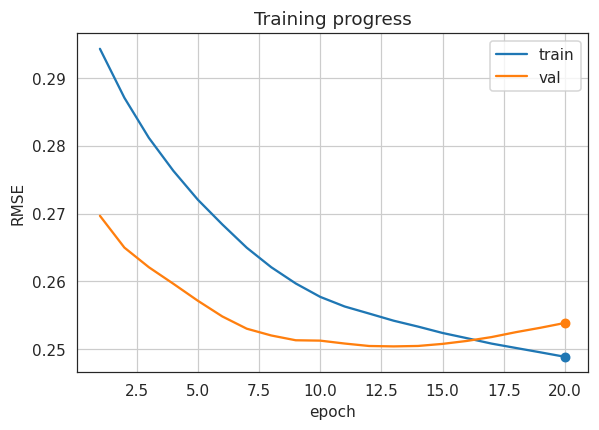

In [11]:
# How many unique trading days does each epoch see?
n_days = len(train_loader.dataset)
print(f"Training sees {n_days} unique trading days per epoch.\n")

print('Using HyperParameters:\n "look_back":', params.look_back_tick, params.hparams)

# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = dual_lstm.lstm_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    clipnorm            = clipnorm,
    device              = params.device
)


In [12]:
# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement_zero = 100.0 * (1.0 - best_val_rmse / rmse_zero_val)
print(f"Improvement over zero‐baseline = {improvement_zero:5.1f}%")

improvement_mean = 100.0 * (1.0 - best_val_rmse / rmse_mean_val)
print(f"Improvement over mean‐baseline = {improvement_mean:5.1f}%")



Champion validation RMSE = 0.250414
Improvement over zero‐baseline =  38.8%
Improvement over mean‐baseline =  12.8%
